In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_community tiktoken langchain-nomic "nomic[local]" langchain-ollama scikit-learn langgraph tavily-python bs4


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Local RAG agent with LLaMA3
We'll combine ideas from paper RAG papers into a RAG agent:

**Routing**: Adaptive RAG (paper). Route questions to different retrieval approaches

**Fallback**: Corrective RAG (paper). Fallback to web search if docs are not relevant to query

**Self-correction**: Self-RAG (paper). Fix answers w/ hallucinations or don’t address question

![alt text](image-2.png)

# Local models
Embedding

GPT4All Embeddings:

pip install langchain-nomic

**LLM**

Use Ollama and llama3.2:

ollama pull llama3.2:3b-instruct-fp16

In [2]:
### LLM
from langchain_ollama import ChatOllama

local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

**Search**

For search, we use Tavily, which is a search engine optimized for LLMs and RAG.

In [3]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


#_set_env("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"] = "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"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

**Tracing**

Optionally, use LangSmith for tracing.

In [4]:
#_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

**Vectorstore**

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)

USER_AGENT environment variable not set, consider setting it to identify your requests.


**Web Search Tool**

In [6]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

API Reference: TavilySearchResults

## Graph
We build the above workflow as a graph using LangGraph.

**Graph state**

The graph state schema contains keys that we want to:

Pass to each node in our graph
Optionally, modify in each node of our graph
See conceptual docs here.

In [7]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

Each node in our graph is simply a function that:

(1) Take state as an input

(2) Modifies state

(3) Write the modified state to the state schema (dict)

See conceptual docs here.

Each edge routes between nodes in the graph.

See conceptual docs here.

In [8]:
from langchain.schema import Document
from langgraph.graph import END

### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


### Nodes
def retrieve(state):
    """
    Args: The current graph state.
    Main code Logic: With question, retrieve relavant documents from vectorstore.
    Returns: A dict which let langgraph update the graph state
    """
    print("---RETRIEVE---")
  
    # retrieved documents in vectorstore with question
    docs = retriever.invoke(state["question"])
    # update the graph state with retrieved documents
    return {"documents": docs}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search
    Args: state (dict): The current graph state.
    Returns: state (dict): Filtered out irrelevant documents and updated web_search state
    """
    
    # Doc grader instructions
    doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""
    # Grader prompt
    doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.
     This carefully and objectively assess whether the document contains at least some information that is relevant to the question.
    Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in state["documents"]:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=state["question"]
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}

def generate(state):
    """
    Generate answer using RAG on retrieved documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    # Prompt
    rag_prompt = """You are an assistant for question-answering tasks. 
    Here is the context to use to answer the question:
    {context} 
    Think carefully about the above context. 
    Now, review the user question:
    {question}
    Provide an answer to this questions using only the above context. 
    Use three sentences maximum and keep the answer concise.
    Answer:"""

    print("---GENERATE---")
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(state["documents"])
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=state["question"])
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}

def web_search(state):
    """
    Web search based based on the question
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": state["question"]})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}

### Edges
def route_question(state):
    """
    Route question to web search or RAG
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    # Prompt
    router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
    The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
    Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.
    Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    
    if state["web_search"] == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    # Hallucination grader instructions
    hallucination_grader_instructions = """
    You are a teacher grading a quiz. 
    You will be given FACTS and a STUDENT ANSWER.
    Here is the grade criteria to follow:
    (1) Ensure the STUDENT ANSWER is grounded in the FACTS.
    (2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.
    Score:
    A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.
    A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
    Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
    Avoid simply stating the correct answer at the outset."""

    # Grader prompt
    hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 
    Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""


    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(state["documents"]), generation=state["generation"].content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Answer grader instructions
        answer_grader_instructions = """You are a teacher grading a quiz.
        You will be given a QUESTION and a STUDENT ANSWER.
        Here is the grade criteria to follow:
        (1) The STUDENT ANSWER helps to answer the QUESTION
        Score:
        A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.
        The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
        A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
        Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
        Avoid simply stating the correct answer at the outset."""

        # Grader prompt
        answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.
        Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""
        
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=state["question"], generation=state["generation"].content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "hallucination"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"  

API Reference: Document | END

# Control Flow


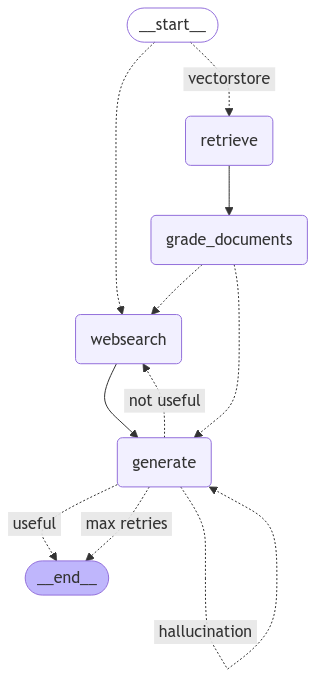

In [9]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

API Reference: StateGraph

In [10]:
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}

for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': 'ca536db4-edfd-4025-b5ca-3a9681cd3148', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks

Trace:
https://smith.langchain.com/public/1e01baea-53e9-4341-a6d1-b1614a800a97/r

In [11]:
# Test on current events
inputs = {
    "question": "What are the models released today for llama3.2?",
    "max_retries": 3,
}

for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Meta Releases Llama 3.2—and Gives Its AI a Voice | WIRED Meta Releases Llama 3.2—and Gives Its AI a Voice Meta Releases Llama 3.2—and Gives Its AI a Voice Meta today also announced Llama 3.2, the first version of its free AI models to have visual abilities, broadening their usefulness and relevance for robotics, virtual reality, and so-called AI agents. Powering Meta AI’s new capabilities is an upgraded version of Llama, Meta’s premier large language model. “With Llama 3.1, Meta showed that open models could finally close the gap with their proprietary counterparts,” says Nathan Benaich, founder and general partner of Air Street Capital, and the author of an influential 

Trace:

https://smith.langchain.com/public/acdfa49d-aa11-48fb-9d9c-13a687ff311f/r